In [1]:
################################################################################
# Copyright 2022 E. Kooistra
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
################################################################################
#
# Author: E. Kooistra, May 2022
# Purpose:
#   Verify the equivalent DFT functions in dft.scad.
#   Calculate DFT for a real input using operations that can also be applied in
#   OpenSCAD.
# Description:
#   OpenSCAD can create matrices and vectors using list comprehension. OpenSCAD
#   also supports matrix multiplication of any dimensions (see numscad.scad).
#   OpenSCAD does not support complex values. Therefore use list comprehension
#   to create DFT matrix W = W_re + W_im * 1j, and then matrix multiplication by
#   separate W_re and W_im to calculate X = DFT(x) = W_re * x + W_im * x * 1j.

# DTF formula
```
       N-1
X(k) = sum x[n] w**nk
       n=0

w = exp(-2 * pi * j / N)
```
n in range(N) times series points (or position series points)

k in range(N) frequency points:
* k = 0 : DC
* k > 0 : weights x(n) with k exp periods 

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
f_eps = 1e-10

## 1. DFT square N x N matrix
```
  X = W * x
  
      |1 1      1       1       ... 1          |
      |1 w      w2      w3      ... w(N-1)     |
      |1 w2     w4      w6      ... w2(N-1)    |
      |1 w3     w6      w9      ... w3(N-1)    |
  W = |...                                     |
      |1 w(N-1) w2(N-1) w3(N-1) ... w(N-1)(N-1)|
```

In [4]:
# DFT size:
# . = nof points of DFT
# . = nof input samples, n in range(N),
# . = nof output frequencies, k in range(N)
N = 1024

# Angle u and complex phasor w
u = 2 * np.pi / N
w = np.exp(1j * -u)
print('angle = %f [degrees]' % np.rad2deg(u))
print('phasor = %s' % str(w))

angle = 0.351562 [degrees]
phasor = (0.9999811752826011-0.006135884649154475j)


In [5]:
# Create nk matrix using numpy arrays
#
#  nk matrix
#     0 1 2 3 n                     nn          nn.T
#  0  0 0 0 0    = 0 * [0 1 2 3]    |0 0 0 0|   |0 1 2 3|
#  1  0 1 2 3    = 1 * [0 1 2 3]    |1 1 1 1|   |0 1 2 3|
#  2  0 2 4 6    = 2 * [0 1 2 3] is |2 2 2 2| * |0 1 2 3|
#  3  0 3 6 9    = 3 * [0 1 2 3]    |3 3 3 3|   |0 1 2 3|
#  k
# 
# Note:
# . Doing nk modulo N is not needed, but fine to do. It keeps the
#   phase within 2 pi. Thus many nk entries are the same, this is
#   what the FFT makes use of to implement the fast DFT. Here the
#   DFT is implemented, so it is slow, but that is fine here.
nn = np.repeat(np.arange(N), N).reshape((N,N))
nk = nn * nn.T
nk = nk % N
nk

array([[   0,    0,    0, ...,    0,    0,    0],
       [   0,    1,    2, ..., 1021, 1022, 1023],
       [   0,    2,    4, ..., 1018, 1020, 1022],
       ...,
       [   0, 1021, 1018, ...,    9,    6,    3],
       [   0, 1022, 1020, ...,    6,    4,    2],
       [   0, 1023, 1022, ...,    3,    2,    1]], dtype=int32)

In [6]:
# W matrix, using numpy array functions
W = w ** nk / N
W_re = np.cos(-u * nk) / N   # = W.real
W_im = np.sin(-u * nk) / N   # = W.imag

# Verify that W matrix calculation methods yield same result
assert np.all(np.abs(W_re - W.real)) < f_eps, "Wrong W_re matrix"
assert np.all(np.abs(W_im - W.imag)) < f_eps, "Wrong W_im matrix"

if N <= 8:
    print(W.shape, W_re.shape, W_im.shape)
    print(f"W = {W}\n")
    print(f"W_re = {W_re}\n")
    print(f"W_im = {W_im}\n")

In [7]:
# W matrix, using list comprehensions and then numpy.asarray(list)
V = np.asarray([ [ np.exp(1j * -u * k * n) for n in range(N) ] for k in range(N) ]) / N;
V_re = np.asarray([ [ np.cos(-u * k * n) for n in range(N) ] for k in range(N) ]) / N;
V_im = np.asarray([ [ np.sin(-u * k * n) for n in range(N) ] for k in range(N) ]) / N;

# Verify that W matrix calculation methods yield same result
assert np.sum(np.abs(W - V)) / N < f_eps, "Wrong V matrix"
assert np.sum(np.abs(W_re - V_re)) / N < f_eps, "Wrong V_re matrix"
assert np.sum(np.abs(W_im - V_im)) / N < f_eps, "Wrong V_im matrix"

## 2. Input signal

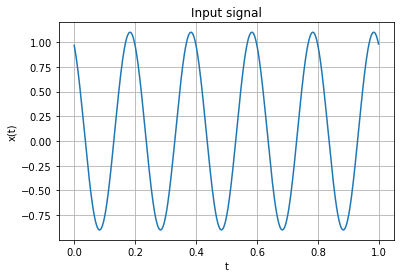

In [8]:
# Input signal
K = 5  # frequency bin, nof periods in N points
dc = 0.1
phi = np.radians(30)
t = np.linspace(0, 1, N, endpoint=False)
x = np.cos(2 * np.pi * t * K + phi) + dc

plt.plot(t, x)
plt.title("Input signal")
plt.xlabel("t")
plt.ylabel("x(t)")
plt.grid()

## 3. Calculate X = DFT(x)

### 3.1 Using numpy FFT for reference

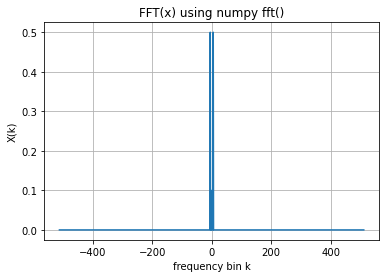

In [9]:
# Using numpy FFT for reference
f = N * np.linspace(-0.5, 0.5, N, endpoint=False)
X_fft = np.fft.fftshift(np.fft.fft(x)) / N

X_fft_abs = np.abs(X_fft)

plt.plot(f, X_fft_abs)
plt.title("FFT(x) using numpy fft()")
plt.xlabel("frequency bin k")
plt.ylabel("X(k)")
plt.grid()

### 3.2 Using DFT matrix and list comprehension

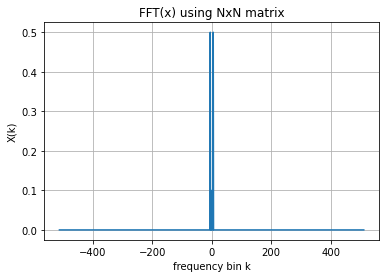

In [10]:
# Using DFT matrix, complex numbers and list comprehension
X_mat = [np.sum([x[xt] * (w**xf)**xt for xt in range(N)]) / N for xf in range(N)]
X_mat = np.fft.fftshift(X_mat)

X_mat_abs = np.abs(X_mat)

plt.plot(f, X_mat_abs)
plt.title("FFT(x) using NxN matrix")
plt.xlabel("frequency bin k")
plt.ylabel("X(k)")
plt.grid()

### 3.3 Using DFT matrix and complex tuples

In [11]:
# Define complex numbers as (re, im) tuples
def complex_mult(aa, bb):
    # aa * bb = aa.re * bb.re - aa.im * bb.im + j * (aa.re * bb.im + aa.im * bb.re)
    return (aa[0]*bb[0] - aa[1]*bb[1], aa[0]*bb[1] + aa[1]*bb[0])

def complex_sum_arr(aa_arr):
    re = 0
    im = 0
    for I in range(N):
        re += aa_arr[I][0]
        im += aa_arr[I][1]
    return (re, im)

def complex_abs(aa):
    return np.abs(aa[0] + 1j * aa[1])

def complex_angle(aa, deg=False):
    return np.angle(aa[0] + 1j * aa[1] , deg=deg)

def complex_abs_arr(aa_arr):
    abs_arr = np.zeros(N)
    for I in range(N):
        abs_arr[I] = complex_abs(aa_arr[I])
    return abs_arr

def complex_angle_arr(aa_arr, deg=False):
    angle_arr = np.zeros(N)
    for I in range(N):
        angle_arr[I] = complex_angle(aa_arr[I], deg=deg)
    return angle_arr

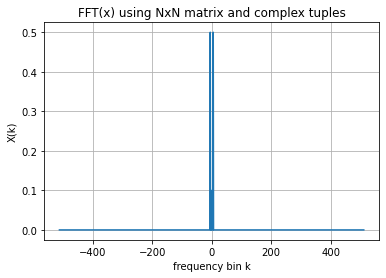

In [12]:
# Using DFT square N x N matrix and complex numbers as (re, im) tuples
XX_mat = [complex_sum_arr([complex_mult((x[n] / N, 0), (np.cos(-u * k * n), np.sin(-u * k * n))) for n in range(N)]) for k in range(N)]

XX_mat = np.fft.fftshift(XX_mat)

XX_mat_abs = complex_abs_arr(XX_mat)
XX_mat_angle = complex_angle_arr(XX_mat, deg=True)

plt.plot(f, XX_mat_abs)
plt.title("FFT(x) using NxN matrix and complex tuples")
plt.xlabel("frequency bin k")
plt.ylabel("X(k)")
plt.grid()
#print(XX_mat_abs)
#print(XX_mat_angle)

### 3.4 Using DFT matrix W and separate W_re, W_im

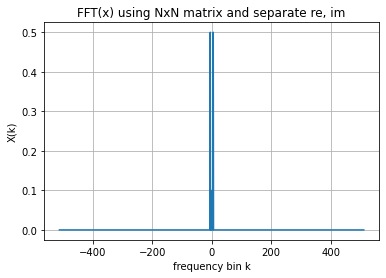

In [13]:
# Using DFT matrix and complex numbers as separate re, im products
if 0:
    # . using list comprehensions and np.asarray(list)
    X_in_re_exp_re = np.asarray([np.sum([x[n] * np.cos(-u * k * n) for n in range(N)]) for k in range(N)]) / N
    X_in_re_exp_im = np.asarray([np.sum([x[n] * np.sin(-u * k * n) for n in range(N)]) for k in range(N)]) / N
else:
    # . using numpy array functions (@ for matrix multiplication)
    X_in_re_exp_re = W_re @ x
    X_in_re_exp_im = W_im @ x

XReal_re = np.fft.fftshift(X_in_re_exp_re)
XReal_im = np.fft.fftshift(X_in_re_exp_im)

# Real input, so input im = 0 and no need to calculate XX_mat_im_re, XX_mat_im_im
XReal_abs = [np.sqrt(XReal_re[k]**2 + XReal_im[k]**2) for k in range(N)]
XReal_angle = [np.arctan2(XReal_im[k], XReal_re[k]) for k in range(N)]

plt.plot(f, XReal_abs)
plt.title("FFT(x) using NxN matrix and separate re, im")
plt.xlabel("frequency bin k")
plt.ylabel("X(k)")
plt.grid()

### 3.5 Conclusion

For Python:
* Using numpy array functions instead of list comprehension and np.asarray, is more clean because it avoids list conversions.
* Has build in complex numbers

For OpenSCAD
* Using list comprehensions resembles for() generate and recursive functions in OpenSCAD. In OpenSCAD one cannot use for-loops to go through array elements.
* Does not have build in complex numbers. Use complex numbers as separate re, im products, is also suitable in OpenSCAD. Using complex values as tuples (re, im) or arrays [re, im] is not useful, because it requires defining custom operator functions (complex_mult, complex_abs, complex_sum).
* Does have matrix multiplication, so use list comprehension to create matrix and vectors, and then matrix multiplication to calculate further, because this makes the matrix operations more clean than using list comprehensions also for matrix operations.


In [14]:
# Try fftshift()
print(np.fft.fftshift([0, 1, 2, 3, 4, 5]))
print(np.fft.fftshift([0, 1, 2, 3, 4]))
print(np.fft.fftshift([0, 1]))
print(np.fft.fftshift([4]))
print(np.fft.fftshift([]))

[3 4 5 0 1 2]
[3 4 0 1 2]
[1 0]
[4]
[]
